# Practice Exercise on Convolutional Neural Networks (CNN)

Welcome to the Practice Exercise on Convolutional Neural Networks (CNN). In this exercise, we will focus on an image classification task where the goal is to predict whether an image contains a cat or a dog. We will work with a dataset of labeled images and build, train, and evaluate a CNN model. This practice will allow you to apply your understanding of CNNs to achieve high accuracy in image classification.

---

## Dataset Overview

### **Dataset Name:** Cats and Dogs Image Dataset

### **Description:**  
The dataset contains images of cats and dogs labeled for classification purposes. Each image belongs to one of the two classes: 'Cat' or 'Dog'. The goal is to classify the images correctly based on the content (i.e., whether the image is of a cat or a dog). The dataset is often used to test image classification models.

### **Features:**
There are two main folders which are:
- `Cat`: Images labeled as containing a cat.
- `Dog`: Images labeled as containing a dog.

### **Target Variable:**
- The goal is to predict whether an image contains a cat or a dog.


## Data Loading and Preprocessing


We will start by loading the dataset and preprocessing the images. This includes:
- Resizing images .
- Normalizing pixel values.

Add more if needed!


In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
from google.colab import drive
import os
import cv2
import tensorflow as tf
import keras

In [28]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
zip_file_path = '/content/drive/MyDrive/Colab Notebooks/PetImages.zip'

extracted_dir = '/content/extracted_files/'

os.makedirs(extracted_dir, exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir)

In [30]:
cat_dir = '/content/extracted_files/PetImages/Cat'
dog_dir = '/content/extracted_files/PetImages/Dog'

cat_images = [os.path.join(cat_dir, img) for img in os.listdir(cat_dir)]
dog_images = [os.path.join(dog_dir, img) for img in os.listdir(dog_dir)]

cat_labels = [0] * len(cat_images)
dog_labels = [1] * len(dog_images)

df_cat = pd.DataFrame({'image_path': cat_images, 'label': cat_labels})
df_dog = pd.DataFrame({'image_path': dog_images, 'label': dog_labels})

df = pd.concat([df_cat, df_dog], ignore_index=True)

df = df.sample(frac=1).reset_index(drop=True)

In [31]:
df.head()

,image_path,label
0,/content/extracted_files/PetImages/Dog/3705.jpg,1
1,/content/extracted_files/PetImages/Dog/4182.jpg,1
2,/content/extracted_files/PetImages/Cat/9602.jpg,0
3,/content/extracted_files/PetImages/Cat/7001.jpg,0
4,/content/extracted_files/PetImages/Dog/4954.jpg,1


In [32]:
df.shape

(25002, 2)

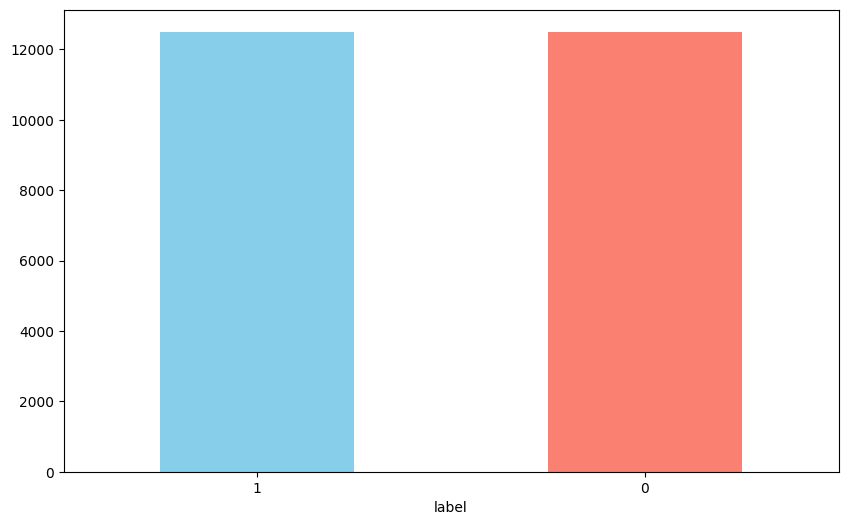

In [33]:
label_counts = df['label'].value_counts()

plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.xticks(rotation=0)
plt.show()

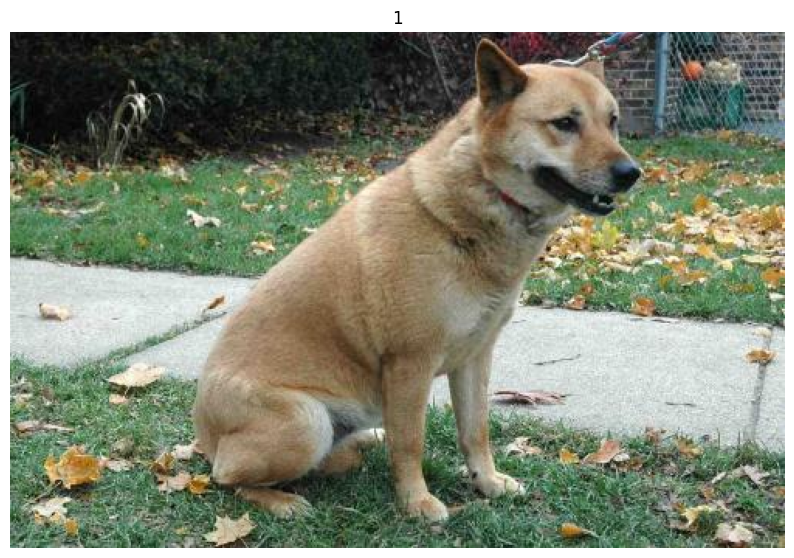

In [34]:
plt.figure(figsize=(10, 10))

for idx, row in df.iterrows():
    image_path = row['image_path']
    label = row['label']

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    plt.imshow(image)
    plt.title(label)
    plt.axis('off')

    break

plt.show()

In [35]:
img_size = (128, 128)

def load_and_preprocess_image(image_path):
    try:
        image = tf.keras.preprocessing.image.load_img(image_path, target_size=img_size)
        image = tf.keras.preprocessing.image.img_to_array(image)
        image = image / 255.0
        return image
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        df.drop(df[df['image_path'] == image_path].index, inplace=True)
        try:
            os.remove(image_path)
            print(f"Image file {image_path} deleted successfully.")
        except OSError as e:
            print(f"Error deleting image file {image_path}: {e}")
        return None

images = []

for img_path in df['image_path'].values:
    image = load_and_preprocess_image(img_path)
    if image is not None:
        images.append(image)

df = np.array(images)

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Error processing image /content/extracted_files/PetImages/Cat/666.jpg: cannot identify image file <_io.BytesIO object at 0x7b0c140f76f0>
Image file /content/extracted_files/PetImages/Cat/666.jpg deleted successfully.
Error processing image /content/extracted_files/PetImages/Dog/Thumbs.db: cannot identify image file <_io.BytesIO object at 0x7b0c14452d40>
Image file /content/extracted_files/PetImages/Dog/Thumbs.db deleted successfully.
Error processing image /content/extracted_files/PetImages/Cat/Thumbs.db: cannot identify image file <_io.BytesIO object at 0x7b0dcd5d5a30>
Image file /content/extracted_files/PetImages/Cat/Thumbs.db deleted successfully.
Error processing image /content/extracted_files/PetImages/Dog/11702.jpg: cannot identify image file <_io.BytesIO object at 0x7b0dcd618bd0>
Image file /content/extracted_files/PetImages/Dog/11702.jpg deleted successfully.


In [36]:
df.shape

(24998, 128, 128, 3)

## Data Splitting
In this section, we will split our dataset into three parts:

* Training set (70%): This portion of the dataset is used to train the CNN model.
* Validation set (15%): This portion is used to validate the model during training, helping us tune hyperparameters and avoid overfitting.
* Test set (15%): This portion is used to evaluate the model after training, to check its generalization to unseen data.

In [41]:
# full_ds = keras.utils.image_dataset_from_directory(
#     '/content/extracted_files/PetImages',
#     label_mode='categorical',
#     seed=1337,
#     image_size=(128, 128),
#     batch_size=32
# )

# num_samples = tf.data.experimental.cardinality(full_ds)

# if not tf.is_tensor(num_samples):
#     num_samples = tf.convert_to_tensor(num_samples, dtype=tf.int64)  # Explicit conversion

# train_size = int(0.7 * num_samples.numpy())
# val_size = int(0.15 * num_samples.numpy())
# test_size = num_samples - train_size - val_size

# train_ds = full_ds.take(train_size)
# val_ds = full_ds.skip(train_size).take(val_size)
# test_ds = full_ds.skip(train_size + val_size)

train_ds, val_ds = keras.utils.image_dataset_from_directory(
    '/content/extracted_files/PetImages',
    label_mode='binary',
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=(128, 128),
    batch_size=32
)

Found 24998 files belonging to 2 classes.
Using 19999 files for training.
Using 4999 files for validation.


## Building the CNN Model


Now, we will define our CNN architecture using `tensorflow.keras`. The architecture will consist of:
- Convolutional layers followed by max-pooling layers
- Flatten layer
- Dense layers
- Output layer


In [42]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [45]:
model = Sequential([
  Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
  MaxPooling2D((2, 2)),

  Conv2D(64, (3, 3), activation='relu'),
  MaxPooling2D((2,2)),

  Flatten(),
  Dense(64, activation='relu'),
  Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


## Training the Model


Train the CNN model using the `fit` function. We will use the training and validation we created earlier.

Fill in the code to train the model for a specified number of epochs.


In [46]:
model.fit(train_ds, batch_size=1000, epochs=10, validation_data=(val_ds))

Epoch 1/10
 12/625 ━━━━━━━━━━━━━━━━━━━━ 33s 54ms/step - accuracy: 0.5121 - loss: 95.4240

InvalidArgumentError: Graph execution error:

Detected at node decode_image/DecodeImage defined at (most recent call last):
<stack traces unavailable>
Detected at node decode_image/DecodeImage defined at (most recent call last):
<stack traces unavailable>
2 root error(s) found.
  (0) INVALID_ARGUMENT:  Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]
	 [[IteratorGetNext]]
	 [[IteratorGetNext/_2]]
  (1) INVALID_ARGUMENT:  Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]
	 [[IteratorGetNext]]
0 successful operations.
0 derived errors ignored. [Op:__inference_one_step_on_iterator_7770]

## Evaluating the Model


After training, evaluate the model on the validation data to check its performance.


## Testing with New Images

Finally, let's test the model with some new images. Preprocess the images and use the trained model to predict whether the image is of a cat or a dog.
